# Comparing Regressions on Collinear Data
In this project the performance of linear regression on principal components is compared to regessions on more conventional ways of preparing data.

In [503]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from operator import concat
from statsmodels.stats.outliers_influence import variance_inflation_factor    

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random

from ISLib import ols
from data_cleaning import data_prep_crime_data


random.seed(1234)
np.random.seed(1234)
split_pct = 0.2

## The Data
Data from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/communities+and+crime) culled from 1990 US Census, 1995 US FBI Uniform Crime Report, 1990 US Law Enforcement Management.

The goal of is to predict crimes per 100k, but theres are barriers to this in the data.

Much of the data is reduant, for examples there are 17 fields that all derive from income:
- medIncome: median household income
- perCapInc: per capita income  
- asianPerCap: per capita income for people with asian heritage 
- blackPerCap: per capita income for african americans 
- hispPerCap: per capita income for people with hispanic heritage
- indianPerCap: per capita income for native americans 
- whitePerCap: per capita income for caucasians
- OtherPerCap: per capita income for people with 'other' heritage
- pctWWage: percentage of households with wage or salary income in 1989
- pctWFarmSelf: percentage of households with farm or self employment income in 1989
- pctWInvInc: percentage of households with investment / rent income in 1989
- pctWSocSec: percentage of households with social security income in 1989
- pctWPubAsst: percentage of households with public assistance income in 1989
- pctWRetire: percentage of households with retirement income in 1989
- medFamInc: median family income (differs from household income for non-family households)
- NumUnderPov: number of people under the poverty level
- PctPopUnderPov: percentage of people under the poverty level

After removing columns with mostly missing data as well as categorical data (which will not be used in this project) there are 1949 instances with 100 potentially predictive data fields. Testing will be done on 80% of the data, with the remaining 20% sequestered for out of sample tests.

In [504]:
#cleaned data and drop columns that are mostly missing or are categorical data
Y_data, X_data = data_prep_crime_data()
x_Train, x_Test, y_Train, y_Test = train_test_split(X_data, Y_data, test_size=split_pct)
                          
print(X_data.shape)
print(x_Train.shape)
print(x_Test.shape)

(1949, 100)
(1559, 100)
(390, 100)


In [505]:
def r_sqr(preds_df: pd.DataFrame):
    cor_matrix = np.corrcoef(preds_df.iloc[:,0],preds_df.iloc[:,1])
    return cor_matrix[0,1]**2

def adjRSq_calc(dataShape, rSq):
    return 1 -(((1-rSq)*(dataShape[0]-1))/(dataShape[0]-dataShape[1]-1))

def rmse(preds_df: pd.DataFrame):
    preds_df['Error'] = preds_df.iloc[:,0] - preds_df.iloc[:,1]
    preds_df['Error'] = preds_df['Error']**2

    return (preds_df['Error'].sum()/len(preds_df['Error']))

def plot_residuals(preds_df:pd.DataFrame):
    fig = plt.figure()
    x = preds_df['Preds']
    y = preds_df['ViolentCrimesPerPop']
    x_line = [0,1]
    y_line = [0,1]
    m, b = np.polyfit(x.values,y.values,1)
    ax = fig.add_subplot(111)
    
    ax.scatter(x,y)
    ax.plot(x, m*x+b,':',color = 'black')
    ax.plot(x_line,y_line,'--',color='red')
    return ax

def compare_residuals(preds_train, preds_test,data_name):
    fig, (ax1,ax2) = plt.subplots(1,2)
    #in sample data
    x1 = preds_train['Preds']
    y1 = preds_train['ViolentCrimesPerPop']
    x1_line = [0,1]
    y1_line = [0,1]
    m1, b1 = np.polyfit(x1.values,y1.values,1)
    ax1.scatter(x1,y1)
    # ax1.plot(x1, m1*x1+b1,':',color = 'black')
    ax1.plot(x1_line,y1_line,'--',color='red')
    ax1.set_title("In Sample Residuals")
    ax1.set_xlabel("Predictions")
    ax1.set_ylabel("Actuals")


    # Test data
    x2 = preds_test['Preds']
    y2 = preds_test['ViolentCrimesPerPop']
    x2_line = [0,1]
    y2_line = [0,1]
    m2, b2 = np.polyfit(x2.values,y2.values,1)
    ax2.scatter(x2,y2)
    # ax2.plot(x2, m2*x2+b2,':',color = 'black')
    ax2.plot(x2_line,y2_line,'--',color='red')
    ax2.set_title("Out Sample Residuals")
    ax2.set_xlabel("Predictions")
    ax2.set_ylabel("Actuals")


    fig.suptitle(data_name)

    fig.set_size_inches(18, 10)


    plt.show()



def performance_stats(out_smpl_preds : pd.DataFrame,
                        in_smpl_preds : pd.DataFrame,
                        xTrain : pd.DataFrame,
                        xTest : pd.DataFrame,
                        print_results = False):
    r2_stat = r_sqr(out_smpl_preds)
    rmse_stat = rmse(out_smpl_preds)
    adjr2 = adjRSq_calc(xTest.shape,r2_stat)
    
    r2_stat_in_smpl = r_sqr(in_smpl_preds)
    rmse_stat_in_smpl = rmse(in_smpl_preds)
    adjr2_in_smpl = adjRSq_calc(xTrain.shape,r2_stat_in_smpl)


    if print_results:
        print("R2: ",r2_stat)
        print("R2 (training): ",r2_stat_in_smpl)
        print("Adj R2: ",adjr2)
        print("Adj R2 (training): ",adjr2_in_smpl)
        print("RMSE: ",rmse_stat)
        print("RMSE (training): ",rmse_stat_in_smpl)

    return [r2_stat, r2_stat_in_smpl, adjr2, adjr2_in_smpl, rmse_stat, rmse_stat_in_smpl]

def standardize_data(independent_df : pd.DataFrame):
    return (independent_df-independent_df.mean())/independent_df.std()

def plot_pca_explain(pca_loadings):
    eig_vectors = pca_loadings.explained_variance_ratio_

    L = pd.Series(eig_vectors)

    variance_explained = L.cumsum() / L.sum()

    var_explained_zero = pd.Series([0])
    variance_plot_data = var_explained_zero.append(variance_explained,ignore_index=True)


    fig, ax = plt.subplots(figsize=(10,5)) #initiate plot
    plt.plot(variance_plot_data,'-o') #lot data with line and point
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # percent format for y axis
    #titles
    ax.set_title('Variance Explained by Principal Component')
    ax.set_xlabel('Principal Component')
    # zip joins x and y coordinates in pairs
    
    x_cord = np.arange(0,(len(variance_plot_data)+1),1)
    y_cord = variance_plot_data.to_numpy()


    for x,y in zip(x_cord,y_cord):

        label = "{:.2f}".format(y)

        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

    fig.set_size_inches(18, 10)
    plt.show()
    

## Test 1: A Baseline Regression

In [506]:
def train_mod_ols(
        yData : pd.DataFrame,
        xData : pd.DataFrame):

    trained = ols.regress(dependent = yData.squeeze(),independent = xData.squeeze())
    return trained

def predict_from_regress(
        yData: pd.DataFrame,
        xData: pd.DataFrame,
        reg_results):
        col_list = list(xData.columns)

        for i in col_list:
            xData[i]=xData[i]*(reg_results.slopes[i])
        
        xData.loc[:,'Preds'] = xData.sum(axis=1).add(reg_results.intercept)
        # xData['Preds'] = xData['Preds'].add(reg_results.intercept)

        results = yData.join(xData['Preds'])

        
        return results

In [507]:
test1_ols = train_mod_ols(y_Train,x_Train)
test1_preds = predict_from_regress(y_Test, x_Test, test1_ols)
test1_preds_in_smpl = predict_from_regress(y_Train, x_Train, test1_ols)

r2_stat_in_smpl = r_sqr(test1_preds_in_smpl)
print("R2:    ",r2_stat_in_smpl)


R2:     0.6700771622272678


## Test 2: Addressing Collinear and Redundant Data for Linear Regression

Because of the many predictors that contain data following similar themes or steaming from the same underlying data the $R^{2}$ will be over stated. The large number of available predictors will also overstate the $R^{2}$. To account for these in the regression we will look $AdjR^{2}$ of the model and remove predictors that demonstrate mulitcollinearity based on their variation inflation factor.

### Adjusted $R^{2}$
$$R^{2}_{adj} = 1 - \left [ \frac{(1-R^{2})(n-1)}{n-k-1} \right ]$$
Where: 
* n: number of points in sample (rows)
* K: number of independent predictors (columns)

The adjusted $R^{2}$ penalizes the normal $R^{2}$ statistic for each additional predictor, so variables that do not add meaningfully to the predictive power of the model will lower the adjusted $R^{2}$



In [508]:
adjr2_in_smpl = adjRSq_calc(x_Train.shape,r2_stat_in_smpl)

print("R2:    ",r2_stat_in_smpl)
print("AdjR2: ",adjr2_in_smpl)

R2:     0.6700771622272678
AdjR2:  0.6472067390185883


The in sample differnece between $R^{2}$ and the adjsuted $R^{2}$ show that at least some of these predictive factors are redudant, but it does not account for collinear data.

In [509]:
r2_stat_out_smpl = r_sqr(test1_preds)
adjr2_out_smpl = adjRSq_calc(x_Test.shape,r2_stat_out_smpl)

print("R2:    ",r2_stat_out_smpl)
print("AdjR2: ",adjr2_out_smpl)

R2:     0.6196212113321105
AdjR2:  0.48622448336177415


### Variation Inflation Factor

$$VIF_{j} = \frac{1}{1 - R_{j}^{2}}$$
Where:
* $VIF_{j}$ : inflation factor for the $j^{th}$ predictor
* $R_{j}^{2}$ : is the r squared for the $j^{th}$ predictor regressed against the rest of the predictive data


### Interperate Variation Inflation Factor (VIF)
VIF denotes the amount by which the variance of the jth predictor is inflated by its correlations with other predictors. Each predictor is regressed against the rest of the data. The higher the $R^{2}$ of the $j^{th}$ variable the higher the VIF. A VIF of 1 means there is no collinearity between this factor and rest, a VIF over 5 likely warrants removal of at least of the highly correlated variables. 


[More info on VIF](https://online.stat.psu.edu/stat462/node/180/)

In [510]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    count_dropped = 0
    print("first 5 variables dropped: ")
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:

            if count_dropped < 5:
                print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                      '\' at index: ' + str(maxloc)+
                      '\' VIF: ',max(vif))

            del variables[maxloc]
            dropped = True
            count_dropped += 1

    print("Dropped colinear variables: ", count_dropped)
    
    print('Count remaining variables:', len(X.columns[variables]))
    # print(X.columns[variables])

    return X.iloc[:, variables]

non_collinear_x_data = calculate_vif_(x_Train)
non_collinear_x_data_out_smpl = x_Test[list(non_collinear_x_data.columns)]

first 5 variables dropped: 
dropping 'TotalPctDiv' at index: 41' VIF:  8868.886018113737
dropping 'PctPersOwnOccup' at index: 66' VIF:  8173.267226178359
dropping 'PersPerOccupHous' at index: 63' VIF:  2316.5979568318
dropping 'OwnOccMedVal' at index: 77' VIF:  1460.7797897803134
dropping 'PctKids2Par' at index: 43' VIF:  1232.267102278417
Dropped colinear variables:  81
Count remaining variables: 20


#### Top 5 Removed Variables
- PctPersOwnOccup: percent of people in owner occupied households
- TotalPctDiv: percentage of population who are divorce
- PersPerOccupHous: mean persons per household
- PctKids2Par: percentage of kids in family housing with two parents
- OwnOccMedVal: owner occupied housing - median value

In [513]:
test2_ols = train_mod_ols(y_Train,non_collinear_x_data)
test2_preds = predict_from_regress(y_Test, non_collinear_x_data_out_smpl, test2_ols)
test2_preds_in_smpl = predict_from_regress(y_Train, non_collinear_x_data, test2_ols)


r2_stat_train = r_sqr(test2_preds_in_smpl)
adjr2_train = adjRSq_calc(non_collinear_x_data.shape,r2_stat_train)

print("R2:    ",r2_stat_train)
print("AdjR2: ",adjr2_train)

R2:     0.5152971846772997
AdjR2:  0.5086746998875946


## Test 3: Linear Regression on Principal Components

In [517]:
def eigen_vectors_n_components(
    indepenant_df : pd.DataFrame,
    num_components: int):
    
    covar_matrix = np.cov(indepenant_df.T)
    pca_loadings = PCA(num_components)
    pca_loadings.fit(covar_matrix)

    #set all factors to positive:

    indepenant_components = x_data_pca(pca_loadings,indepenant_df,num_components)
    sign = np.sign(indepenant_components.mean())
    pca_loadings.components_ = pca_loadings.components_.T @ np.diag(sign)
    pca_loadings.components_ = pca_loadings.components_.T

    return pca_loadings



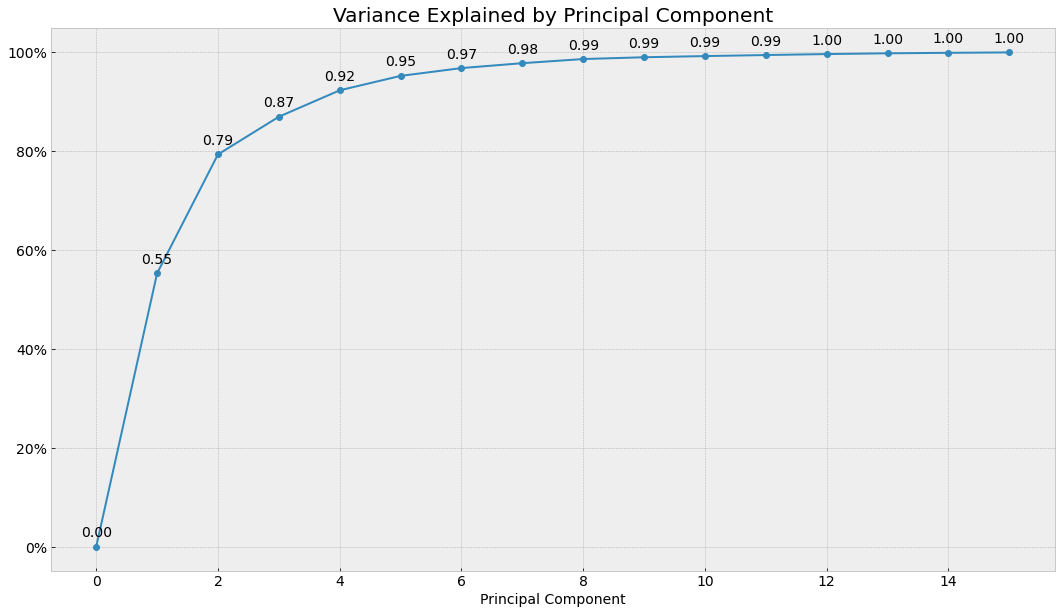

In [515]:
standardized_xtrain = standardize_data(x_Train)
standardized_xtest = standardize_data(x_Test)
pca_loadings = eigen_vectors_n_components(standardized_xtrain,15)


plot_pca_explain(pca_loadings)


Four principal components can explain 92% of the variance in the predictive data.

Next the loadings determined from the training data are applied to the test and training x data.

In [516]:
def x_data_pca(
        pca_loadings,
        standardized_x : pd.DataFrame,
        num_factors : int):

    pca_col_names = []
    for i in range(1,(num_factors+1)):
        col_name = concat("PC_",str(i))
        pca_col_names.append(col_name)

    eig_vectors = pca_loadings.components_

    #projection matrix:
    projection_matrix = (eig_vectors.T[:,:num_factors])
  
    X_pca = standardized_x.dot(projection_matrix)
    X_pca.columns = pca_col_names
    
    return X_pca

In [519]:
X_pca_train = x_data_pca(pca_loadings,standardized_xtrain,4)
X_pca_test = x_data_pca(pca_loadings,standardized_xtest,4)

trained_ols_on_pca = train_mod_ols(y_Train,X_pca_train)
preds_pca_out_sample = predict_from_regress(y_Test, X_pca_test, trained_ols_on_pca)
preds_pca_in_sample = predict_from_regress(y_Train, X_pca_train, trained_ols_on_pca)


                   normal ols  Noncollinear ols   PCA ols
Performance Stats                                        
R2                   0.619621          0.496263  0.519004
R2 in sample         0.670077          0.515297  0.527860
Adj R2               0.486224          0.467517  0.512741
Adj R2 in sample     0.647207          0.508675  0.526340
RMSE                 0.015092          0.019972  0.019073
RMSE in sample       0.014099          0.020785  0.020176


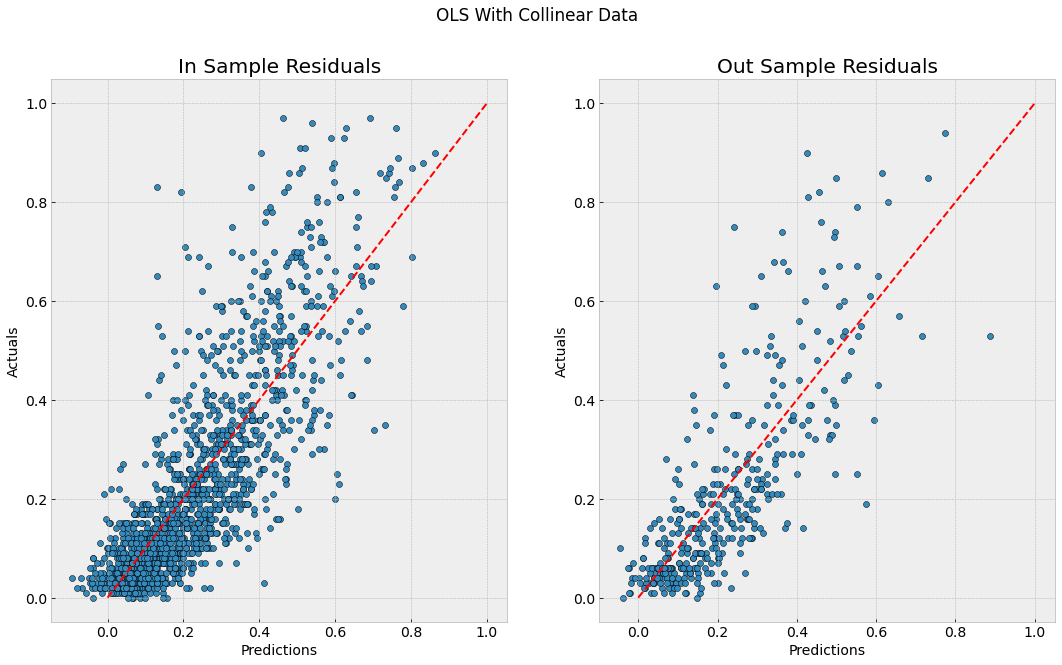

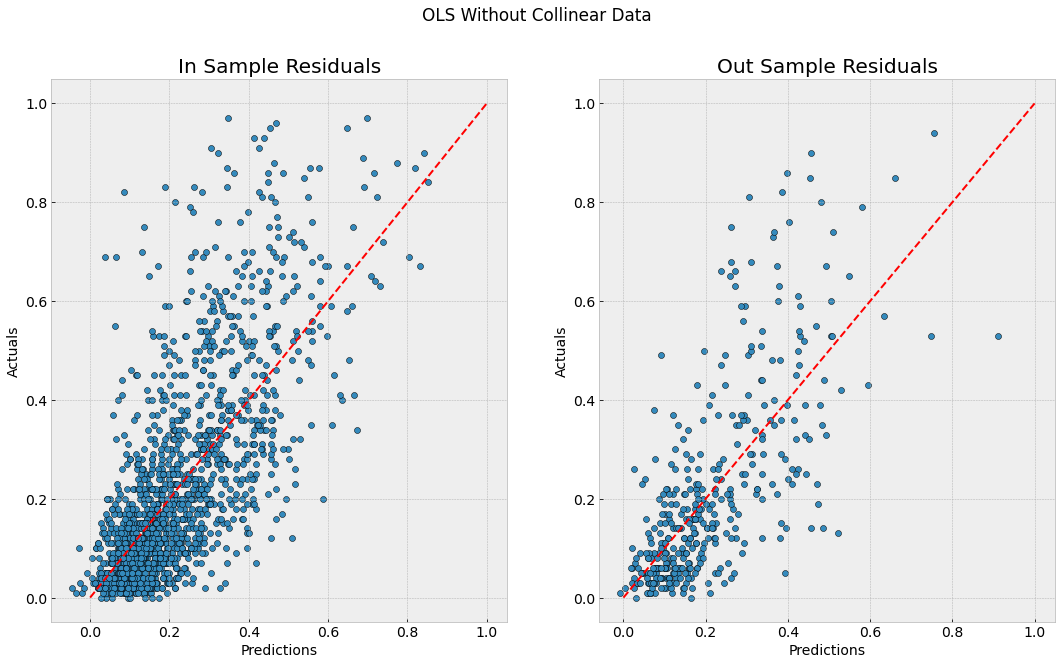

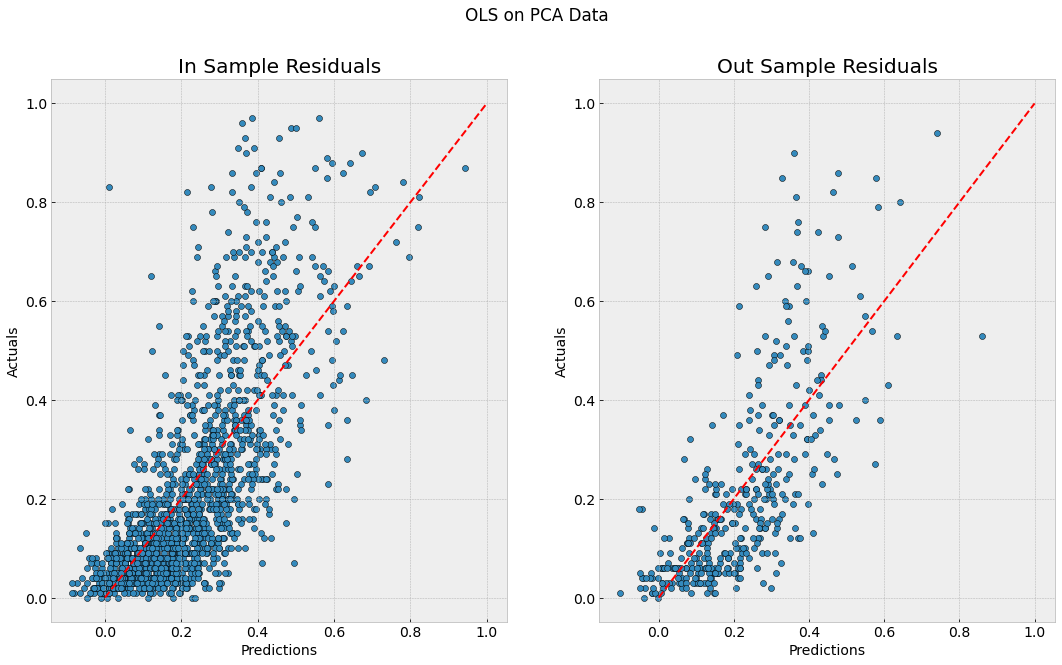

In [520]:
test1_ols = performance_stats(test1_preds, test1_preds_in_smpl,x_Train, x_Test)
test2_noncollinear = performance_stats(test2_preds, test2_preds_in_smpl,non_collinear_x_data, non_collinear_x_data_out_smpl)
test3_pca = performance_stats(preds_pca_out_sample, preds_pca_in_sample,X_pca_train, X_pca_test)

data_dict = {
    "Performance Stats" : ["R2", "R2 in sample", "Adj R2", "Adj R2 in sample","RMSE","RMSE in sample"],
    "normal ols" : test1_ols,
    "Noncollinear ols" : test2_noncollinear,
    "PCA ols" : test3_pca
}

df = pd.DataFrame(data_dict)
print(df.set_index('Performance Stats'))


compare_residuals(test1_preds_in_smpl,test1_preds, "OLS With Collinear Data")
compare_residuals(test2_preds_in_smpl,test2_preds, "OLS Without Collinear Data")
compare_residuals(preds_pca_in_sample,preds_pca_out_sample, "OLS on PCA Data")